In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, cv

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

import pandas.io.sql as psql
import psycopg2
conn = psycopg2.connect(dbname='churn', 
                        user='postgres',
                        password='postgres',
                        host='bi-assess.cvtbaved9qqg.us-west-2.rds.amazonaws.com',
                        port=5432)

In [2]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', None, 'display.max_columns', None)

## Part 1: Creating the churn attribute

Let's start by loading up the datasets into a database, since the intent is to demonstrate competency in SQL. I created a free micro instance on AWS RDS, with 100GB of storage.

In [ ]:
dim_account = os.path.join('data', 'dim_account', '000')
dim_calendar = os.path.join('data', 'dim_calendar', '000')
dim_product = os.path.join('data', 'dim_product', '000')
dim_territory = os.path.join('data', 'dim_territory', '000')
fact_sales_revenue = os.path.join('data', 'fact_sales_revenue', '000')

In [ ]:
# 0 means open
conn.closed

In [ ]:
create_dim_account = """
    CREATE TABLE dim_account (
        payer_account_id TEXT, 
        payer_account_company_name TEXT,
        payer_account_registration_date TIMESTAMP WITHOUT TIME ZONE,
        payer_account_status_code TEXT,
        payer_account_role_name TEXT,
        payer_account_creation_date TIMESTAMP WITHOUT TIME ZONE,
        payer_account_last_update_date TIMESTAMP WITHOUT TIME ZONE,
        payer_account_registration_tax_country_code TEXT,
        is_payer_account_bill_in_90_days CHAR(1),
        is_payer_account_enterprise CHAR(1),
        is_payer_account_domain_free_domain CHAR(1),
        is_payer_account_on_enterprise_support CHAR(1),
        is_payer_account_on_business_support CHAR(1),
        is_payer_account_fraud CHAR(1),
        is_payer_account_suspended CHAR(1),
        is_payer_account_internal CHAR(1),
        is_payer_account_inp_terminated CHAR(1),
        is_payer_account_on_behalf_of CHAR(1),
        is_payer_account_tax_exempt CHAR(1),
        is_payer_account_reseller CHAR(1),
        payer_account_first_billing_reporting_date TIMESTAMP WITHOUT TIME ZONE,
        payer_account_first_payment_reporting_date TIMESTAMP WITHOUT TIME ZONE,
        payer_account_first_usage_date TIMESTAMP WITHOUT TIME ZONE
    );
"""

create_dim_calendar = """
    CREATE TABLE dim_calendar (
        calendar_sid INTEGER,
        calendar_date DATE,
        day_of_week_name TEXT,
        day_of_week_number INTEGER,
        day_of_week_code TEXT,
        day_of_quarter_number INTEGER,
        day_of_year_number INTEGER,
        calendar_period TEXT,
        week_id INTEGER,
        prior_week_id INTEGER,
        subsequent_week_id INTEGER,
        week_number INTEGER,
        week_code TEXT,
        month_id INTEGER,
        prior_month_id INTEGER,
        subsequent_month_id INTEGER,
        month_number INTEGER,
        month_code TEXT,
        month_num_of_days INTEGER,
        year_id INTEGER,
        prior_year_id INTEGER,
        subsequent_year_id INTEGER,
        year_number INTEGER,
        year_code TEXT,
        ytd_flag BOOLEAN,
        yoy_flag BOOLEAN,
        report_month_flag BOOLEAN,
        prospecting_day_flag BOOLEAN
    );
"""

create_dim_product = """
    CREATE TABLE dim_product (
        product_sid TEXT,
        product_line_name TEXT,
        product_name TEXT,
        sub_product_name TEXT,
        service_group_name TEXT,
        product_companyn_name TEXT
    );
"""

create_dim_territory = """
    CREATE TABLE dim_territory (
        territory_sid TEXT,
        region TEXT,
        sub_region TEXT,
        territory_code TEXT,
        segment TEXT
    );
"""

create_fact_sales_revenue = """
    CREATE TABLE fact_sales_revenue (
       territory_sid TEXT,
       payer_account_id TEXT,
       month_id INTEGER,
       product_sid TEXT,
       sales_revenue NUMERIC(38,6)
    );
"""

In [ ]:
tables = [
#    'dim_account',
#    'dim_calendar',
#    'dim_product',
#    'dim_territory',
#    'fact_sales_revenue'
]

Some utility functions:

In [ ]:
def select_print(query):
    try:
        cur = conn.cursor()
        cur.execute(query)
        data = cur.fetchall()
        print(data)
        conn.commit()
    except psycopg2.OperationalError as oe:
        print(oe)

In [ ]:
def create_table(tablename):
    try:
        cur = conn.cursor()
        func_name = 'create_' + tablename
        cur.execute(eval(func_name))
        conn.commit()
        print('Table ' + tablename + ' created.')
    except psycopg2.OperationalError as oe:
        print(oe)

In [ ]:
def copy_from_file(filepath, tablename):
    try:
        cur = conn.cursor()
        f = open(filepath, 'r')
        cur.copy_from(f, tablename, sep=',')
        conn.commit()
        f.close()
        print(filepath + ' copied into table ' + tablename + '.')
    except psycopg2.OperationalError as oe:
        print(oe)

In [ ]:
def execute_only(query):
    try:
        cur = conn.cursor()
        cur.execute(query)
        conn.commit()
        print('Done.')
    except psycopg2.OperationalError as oe:
        print(oe)

In [ ]:
%%time
for table in tables:
    create_table(table)
    copy_from_file(eval(table), table)

First there are two things I want to be sure of: 

1. That each row in dim_account is distinct, i.e. we are storing state instead of transactions. E.g. when an account is suspended, and UPDATE is done, not an INSERT

2. That each row in fact_revenue_sales is the total monthly sales for that month_id, i.e. we are storing aggregates instead of transactions. If not, we need to aggregate the transactions to get the total monthly sales, since churn is a function of change in monthly sales.

In [ ]:
%%time
select_print('SELECT COUNT(*) from dim_account;')
select_print('SELECT COUNT(DISTINCT payer_account_id) FROM dim_account;')

Since both selects have the same value of 21053889, we've confirmed that dim_account stores the state of each account as identified by payer_account_id.

We have a lot of payer accounts, and the file dump of the fact_sales_revenue was roughly 1/4 the size of dim_account. How many accounts even have any transactions at all?

In [ ]:
%%time
select_print('SELECT COUNT(DISTINCT payer_account_id) FROM fact_sales_revenue;')

A mere 0.69% of payer accounts actually have transactions on file.. Let's set dim_account aside for now, and dive into fact_revenue_sales to answer the second question.

In [ ]:
select_num_transactions_per_month = """
    SELECT num_transactions, COUNT(payer_account_id) AS num_account_months
    FROM (SELECT payer_account_id, month_id, COUNT(sales_revenue) as num_transactions
        FROM fact_sales_revenue
        GROUP BY payer_account_id, month_id) subquery
    GROUP BY num_transactions
    ORDER BY num_transactions ASC;
"""

num_transactions_per_month_df = psql.read_sql(select_num_transactions_per_month, conn)

In [ ]:
plt.figure(figsize=(20,8))
X = num_transactions_per_month_df.num_transactions
Y = num_transactions_per_month_df.num_account_months

ax = sns.barplot(x=X, y=Y)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.show()

Here we see a distribution of the number of transactions an account makes in a single month. It is of course heavily skewed toward a low number of transactions within a single month, but we see an interested uptick at 5 transactions per month, from whence it declines again. 

This suggests that there are at least two distributions of low-transaction payer-months, one which declines sharply from 1 transaction, and another which declines more gradually from 6 transactions per month.

Business-wise this means that there is some differentiable group of player-months where the number of transactions is consistantly high. This could mean either an opportunity to optimize by consolidating payments, or an opportunity to find out what is leading to more transactions in the latter group, and use it to increase the transaction count in the former group. 

* * *

However, we have not answered the second question we initially had: whether or not there is a single transaction per payer-month, i.e. whether the value in sales_revenue is for the entire month, or if we need to aggregate them per payer-month.

In [ ]:
%%time
select_multiple_transactions_per_payer_month = """
    SELECT * 
    FROM (SELECT payer_account_id, month_id, COUNT(sales_revenue) AS num_transactions
        FROM fact_sales_revenue
        GROUP BY payer_account_id, month_id) subquery
    WHERE num_transactions > 1
    LIMIT 100;
"""

multiple_transactions_per_payer_month_df = psql.read_sql(select_multiple_transactions_per_payer_month, conn)
print(multiple_transactions_per_payer_month_df.head())

And right away we can see easily enough that there are plenty of payers with more than one sales_revenue per month. Our hunch was correct, this is transactional data that needs to be aggregated.

Let's create another table to store the total monthly sales revenue of each payer.

In [ ]:
# %%time
# select_total_revenue_per_payer_month = """
#     SELECT payer_account_id, month_id, SUM(sales_revenue) as month_sales_revenue
#     INTO TABLE monthly_sales_revenue
#     FROM fact_sales_revenue
#     GROUP BY payer_account_id, month_id
# """

# execute_only(select_total_revenue_per_payer_month)

Also let's create a monthly calendar table for joining.

In [ ]:
# create_monthly_calendar = """
#     SELECT month_id, month_number, year_number
#     INTO monthly_calendar
#         FROM dim_calendar
#         GROUP BY month_id, month_number, year_number
# """

# execute_only(create_monthly_calendar)

Now we just need to add a column storing the churn attribute. 

An account is defined as having churned in a given month if its total transaction revenue in the previous year's month of December was above 1, but the same value in the month in concern is below 1. We can phrase this as a boolean conditional:

```
churn = previous_dec_revenue > 1 and month_sales_revenue < 1
```

We already created the month_sales_revenue attribute, so we just need to create the previous_dec_revenue attribute, then create the churn attribute based on these two attributes.

In [ ]:
# %%time
# select_into_churn = """
#     SELECT msr.payer_account_id, 
#         msr.month_id, mc.month_number, 
#         mc.year_number, 
#         msr.month_sales_revenue, 
#         mc2.year_number AS previous_year_number, 
#         mc2.month_id AS previous_dec_month_id, 
#         msr2.month_sales_revenue AS previous_dec_month_sales_revenue, 
#         (msr2.month_sales_revenue > 1 AND msr.month_sales_revenue < 1) AS churn
#     INTO churn
#         FROM monthly_sales_revenue msr
#         LEFT JOIN monthly_calendar mc ON msr.month_id = mc.month_id
#         LEFT JOIN monthly_calendar mc2 ON mc.year_number-1 = mc2.year_number AND mc2.month_number = 12
#         LEFT JOIN monthly_sales_revenue msr2 ON mc2.month_id = msr2.month_id AND msr2. payer_account_id = msr.payer_account_id
# """

# execute_only(select_into_churn)

Something I learnt about Postgres' handling of boolean values:

```
null AND false = false
null AND true = null
```

and the same goes if you swap the places of the conditions. 

This means that in our resulting table, the meanings of the churn variable are:
-  true : previous_dec_revenue > 1 __and__ month_sales_revenue < 1 
-  null : previous_dec_revenue = null __and__ month_sales_revenue < 1
-  false: previous_dec_revenue < 1 __or__ month_sales_revenue > 1, since null previous_dec_revenue means it was 0

In other words, we can consider null churn to be the same as false, since it means that previous_dec_revenue == 0.

With this, we have created the churn variable in the database. The next step is to find out the factors influencing churn, and since it's much more exploratory, I'll try to do most of it in Python using Pandas. There are 1160280 rows in the churn table, so it should be managable. Of course, I'll still have to make SQL queries to retrieve data to engineer features with. 

For more notes on the problems I faced along the way creating the churn variable, and how I approached them, please see the footnote at the bottom of this notebook. 

## Part 2: Identifying the causes of churn

Churn is an attribute identified by two factors: payer_account_id, and month_id. Hence, whatever is affecting churn must be a characteristic of one of these two entities: payer accounts, and the month in concern.

Since our time aggregation is on a monthly level, we don't really have things like day of week to worry about; it's unlikely that the number of days in a month is a factor related to churn. We do have to contend with how to treat the ordinal nature of transactions when predicting churn, but let's worry about that later on. 

With regard to payer accounts, we can break descriptors down into two components: account attributes, and transaction attributes. Transaction attributes in aggregate also act as account attributes. 

Account attributes are available simply by joining dim_account onto churn. We already know that dim_account comprises distinct rows for each account, so no preprocessing needed there. 

Transaction attributes are available from dim_product and dim_territory. Before we join these tables onto churn, we need to better understand them the same way we figured out dim_account. First, let's confirm the level of aggregation of these two tables.

In [ ]:
%%time
select_print('SELECT COUNT(*) from dim_product;')
select_print('SELECT COUNT(DISTINCT product_sid) FROM dim_product;')

In [ ]:
%%time
select_print('SELECT COUNT(*) from dim_territory;')
select_print('SELECT COUNT(DISTINCT territory_sid) FROM dim_territory;')

We've confirmed that these are mapping tables containing attributes of products and territories. However, products and territories are aggregated in fact_sales_revenue on a transaction basis, while churn is labeled on an aggregated monthly basis. 

In order to understand churn on a finer grain, transactional level, let's map churn back to fact_sale_revenue, and add all the product and territory attributes in for good measure.

In [ ]:
# %%time
# select_into_churn_factors = """
#     SELECT fsr.territory_sid, fsr.payer_account_id, fsr.month_id, fsr.product_sid, fsr.sales_revenue, 
#         churn.month_number, churn.year_number, churn.month_sales_revenue, churn.previous_dec_month_sales_revenue, churn.churn,
#         dt.region, dt.sub_region, dt.territory_code, dt.segment,
#         dp.product_line_name, dp.product_name, dp.sub_product_name, dp.service_group_name, dp.product_companyn_name
#     INTO churn_factors
#         FROM fact_sales_revenue fsr
#         LEFT JOIN churn ON fsr.payer_account_id = churn.payer_account_id AND fsr.month_id = churn.month_id
#         LEFT JOIN dim_territory dt ON dt.territory_sid = fsr.territory_sid
#         LEFT JOIN dim_product dp ON dp.product_sid = fsr.product_sid
#         ;
# """

# execute_only(select_into_churn_factors)

Now that's done, let's begin trying to work with the data locally to figure out what the churn risk factors are.

In [3]:
churn_factors_filepath = os.path.join('output', 'churn_factors.csv')

In [ ]:
# %%time 
# select_churn_factors = """
# SELECT *
#     FROM churn_factors
#     ORDER BY payer_account_id, month_id, territory_sid, product_sid ASC;
# """

# df = psql.read_sql(select_churn_factors, conn)
# df.to_csv(churn_factors_filepath, index=False)

In [4]:
df = pd.read_csv(churn_factors_filepath)

We do need to re-aggregate this table back into month_sales_revenue, and create new factors that are aggregates of the transaction-wise features, but for now let's take a look at the transactions themselves.

In [5]:
def explore_plot(df):
    fig, axes = plt.subplots(nrows=5, ncols=2)
    fig.set_size_inches(16, 20)

    df.month_number.value_counts(dropna=False).sort_index().plot('bar', title='Transactions per month', ax=axes[0,0])
    df.year_number.value_counts(dropna=False).sort_index().plot('bar', title='Transactions per year', ax=axes[0,1])
    df.month_id.value_counts(dropna=False).sort_index().plot('bar', title='Transactions per month in year', ax=axes[1,0])
    df.region.value_counts(dropna=False).plot('barh', title='Transactions per region', ax=axes[1,1])
    df.sub_region.value_counts(dropna=False).plot('barh', title='Transactions per sub-region', ax=axes[2,0])
    df.territory_code.value_counts(dropna=False).plot('barh', title='Transactions per territory', ax=axes[2,1])
    df.product_line_name.value_counts(dropna=False).plot('bar', title='Transactions per product line', ax=axes[3,0])
    df.sub_product_name.value_counts(dropna=False).plot('bar', title='Transactions per sub_product', ax=axes[3,1])
    df.service_group_name.value_counts(dropna=False).plot('bar', title='Transactions per sub-product', ax=axes[4,0])
    df.churn.value_counts(dropna=False).plot('barh', title='Transactions by churned and non-churned payers', ax=axes[4,1])
    
    plt.show()

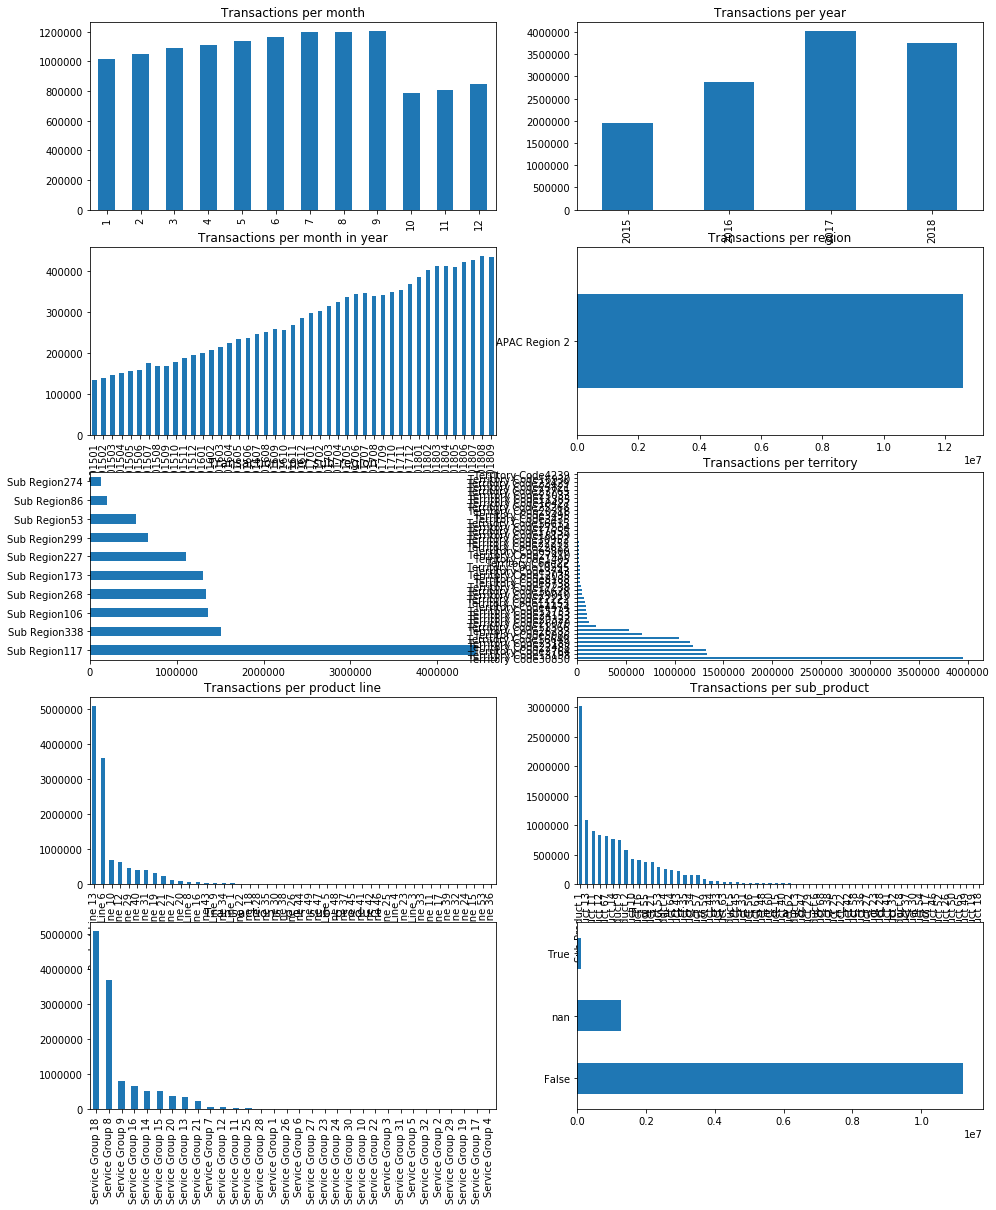

In [6]:
explore_plot(df)

In [ ]:
# For whatever reason, these two features don't plot well,
# probably because the skew is rather extreme and there are many possible values.
print(df.product_name.value_counts(dropna=False))

In [7]:
print(df.product_companyn_name.value_counts(dropna=False))

Product Company 1       12569231
Product Company 1662    2190    
Product Company 1476    1418    
Product Company 2860    1375    
Product Company 458     1310    
Product Company 159     1172    
Product Company 108     1123    
Product Company 9       1116    
Product Company 482     1044    
Product Company 148     875     
Product Company 2318    839     
Product Company 1911    756     
Product Company 1962    646     
Product Company 1628    632     
Product Company 303     544     
Product Company 11      538     
Product Company 489     488     
Product Company 1407    441     
Product Company 481     429     
Product Company 76      419     
Product Company 204     410     
Product Company 467     404     
Product Company 4904    381     
Product Company 1116    379     
Product Company 760     349     
Product Company 415     342     
Product Company 2051    328     
Product Company 291     328     
Product Company 295     316     
Product Company 350     290     
Product Co

Let's eyeball the same charts for only the transactions of customers that churned.

In [8]:
churn_transactions_df = df[df['churn'] == True]

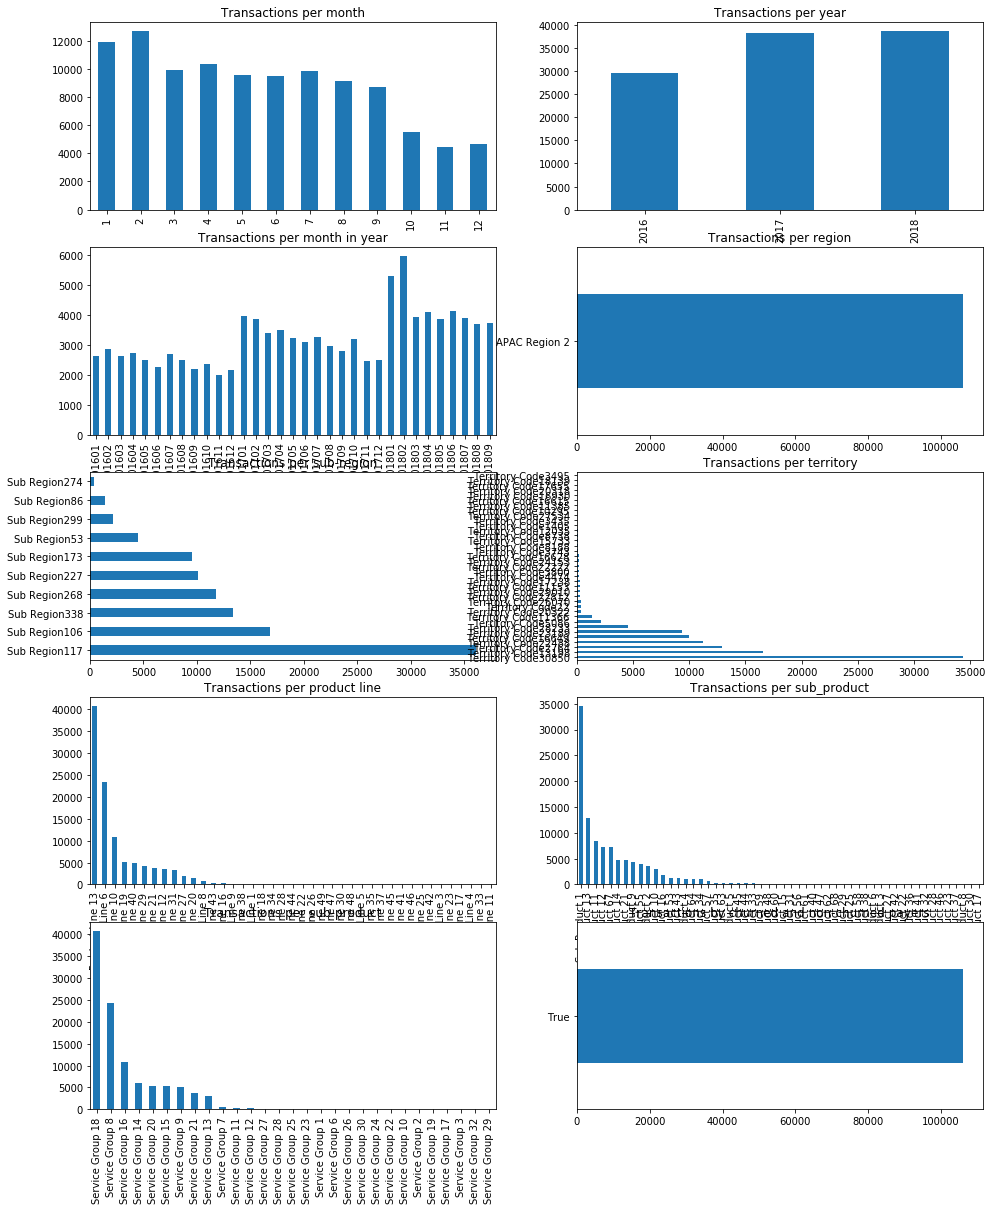

In [9]:
explore_plot(churn_transactions_df)

At a glance, the only stark difference is that there are more transactions by churned payer accounts in January and February.

Now, we want to understand feature importance, and importance is really relative to some purpose. In our case, it should be a feature's importance to determining whether a customer will churn; so, any feature importance we engineer will be relative to the method used to determine whether a customer will churn. However, we might interpret the general overall ranking of features to be related to the use of other classification methods.

For this example, we will use catboost's CatBoostClassifier to try to determine what features affect churn. We will engineer some month-aggregated features, then try to fit the classifier to see how much the features contribute to predicting it. These are the features we will engineer: 

- cumulative_num_transactions
- num_transactions
- mean_num_transactions_per_month
- max_num_transactions_per_month
- min_num_transactions_per_month
- cumulative_revenue
- total_revenue_in_month
- mean_transaction_revenue_per_month
- max_transaction_revenue_per_month
- min_transaction_revenue_per_month
- top_product_line_name
- top_product_line_num_transactions
- top_product_line_percent_transactions
- top_product_line_revenue
- top_product_line_revenue_percent
- top_product_name
- top_product_num_transactions
- top_product_percent_transactions
- top_product_cumulative_revenue
- top_product_cumulative_revenue_percent
- num_product_lines
- num_product_names
- num_sub_product_names

There are many other features we could engineer, but the more there are the longer it takes to train the model, and I feel like I'm overthinking this assignment already, so let's begin with just this.

In [10]:
grouped = df.groupby(['payer_account_id', 'month_id'])

In [ ]:
# %%time
# feature_df = grouped['sales_revenue'].agg('count').groupby(level=[0]).cumsum().to_frame()
# feature_df.columns=['cumulative_num_transactions']
# feature_df['num_transactions'] = grouped['sales_revenue'].agg('count')
# mean_transactions = feature_df.reset_index().groupby(['payer_account_id']).expanding().agg('mean')['num_transactions']
# mean_transactions.index = feature_df.index
# #timing up to here
# feature_df['mean_num_transactions_per_month'] = mean_transactions
# max_transactions = feature_df.reset_index().groupby(['payer_account_id']).expanding().agg('max')['num_transactions']
# max_transactions.index = feature_df.index
# feature_df['max_num_transactions_per_month'] = max_transactions
# min_transactions = feature_df.reset_index().groupby(['payer_account_id']).expanding().agg('min')['num_transactions']
# min_transactions.index = feature_df.index
# feature_df['min_num_transactions_per_month'] = min_transactions

# cum_rev = grouped['sales_revenue'].agg(np.sum).groupby(level=[0]).cumsum()
# feature_df['cumulative_revenue'] = cum_rev
# feature_df['total_revenue_in_month'] = grouped['sales_revenue'].agg('sum')
# mean_revenue = feature_df.reset_index().groupby(['payer_account_id']).expanding().agg('mean')['total_revenue_in_month']
# mean_revenue.index = feature_df.index
# feature_df['mean_transaction_revenue_per_month'] = mean_revenue
# max_revenue = feature_df.reset_index().groupby(['payer_account_id']).expanding().agg('max')['total_revenue_in_month']
# max_revenue.index = feature_df.index
# feature_df['max_transaction_revenue_per_month'] = max_revenue
# min_revenue = feature_df.reset_index().groupby(['payer_account_id']).expanding().agg('min')['total_revenue_in_month']
# min_revenue.index = feature_df.index
# feature_df['min_transaction_revenue_per_month'] = min_revenue

# feature_df['top_product_line_name'] = grouped['product_line_name'].agg(pd.Series.mode)
# feature_df['product_line_name_list'] = grouped['product_line_name'].apply(list)
# feature_df['top_product_line_num_transactions'] = feature_df.apply(lambda x: x['product_line_name_list'].count(x['top_product_line_name']) 
#                                                              if type(x['top_product_line_name']) == str
#                                                             else x['product_line_name_list'].count(x['top_product_line_name'][0]), axis=1)
# feature_df['top_product_line_percent_transactions'] = feature_df.apply(lambda x: x['top_product_line_num_transactions']/x['num_transactions'], axis=1)

# feature_df['num_product_lines'] = grouped['product_line_name'].nunique()
# feature_df['num_product_names'] = grouped['product_name'].nunique()
# feature_df['num_sub_product_names'] = grouped['sub_product_name'].nunique()

# feature_df.to_csv(os.path.join('output', 'feature.csv'))

In [11]:
feature_df = pd.read_csv(os.path.join('output', 'feature.csv'))
feature_df.shape

(1160280, 19)

Now we'll just pull out the churn and date features and join them so we can save the processing time of aggregating them.

In [12]:
churn_filepath = os.path.join('output', 'churn.csv')

In [ ]:
# %%time 
# select_churn = """
# SELECT *
#     FROM churn
#     ORDER BY payer_account_id, month_id;
# """

# df = psql.read_sql(select_churn, conn)
# df.to_csv(churn_filepath, index=False)

In [13]:
churn_df = pd.read_csv(churn_filepath)

In [14]:
churn_df = churn_df[['payer_account_id', 'month_id', 'month_number', 'year_number', 'churn']]

In [15]:
churn_df.shape

(1160280, 5)

In [16]:
combined_features = feature_df.merge(churn_df, on=['payer_account_id', 'month_id'])

In [17]:
combined_features.drop('product_line_name_list', axis=1, inplace=True)
combined_features[['cumulative_num_transactions', 
                   'num_transactions', 
                   'top_product_line_num_transactions',
                   'num_product_lines',
                   'num_product_names',
                   'num_sub_product_names'
                  ]] = combined_features[['cumulative_num_transactions', 
                   'num_transactions', 
                   'top_product_line_num_transactions',
                   'num_product_lines',
                   'num_product_names',
                   'num_sub_product_names'
                  ]].apply(lambda x: x.astype(float))
combined_features['churn'].fillna(False, inplace=True)

In [18]:
combined_features.shape

(1160280, 21)

Now let's fit the model.

In [19]:
X = combined_features.drop('churn', axis=1)
y = combined_features.churn.map({True: 1, False: 0})

In [20]:
print(X.dtypes)
categorical_features_indices = np.where(X.dtypes != np.float)[0]

payer_account_id                         object 
month_id                                 int64  
cumulative_num_transactions              float64
num_transactions                         float64
mean_num_transactions_per_month          float64
max_num_transactions_per_month           float64
min_num_transactions_per_month           float64
cumulative_revenue                       float64
total_revenue_in_month                   float64
mean_transaction_revenue_per_month       float64
max_transaction_revenue_per_month        float64
min_transaction_revenue_per_month        float64
top_product_line_name                    object 
top_product_line_num_transactions        float64
top_product_line_percent_transactions    float64
num_product_lines                        float64
num_product_names                        float64
num_sub_product_names                    float64
month_number                             int64  
year_number                              int64  
dtype: object


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 5432)

C:\Users\space\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [25]:
model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.03,
    random_seed=5432,
    thread_count = 8,
    use_best_model=True
)

In [23]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [26]:
model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_test, y_test),
#     logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5689414	test: 0.5689456	best: 0.5689456 (0)	total: 837ms	remaining: 2m 46s
1:	learn: 0.5191800	test: 0.5192219	best: 0.5192219 (1)	total: 1.27s	remaining: 2m 5s
2:	learn: 0.4294243	test: 0.4294564	best: 0.4294564 (2)	total: 1.9s	remaining: 2m 5s
3:	learn: 0.3525613	test: 0.3525885	best: 0.3525885 (3)	total: 2.92s	remaining: 2m 23s
4:	learn: 0.3217404	test: 0.3218289	best: 0.3218289 (4)	total: 3.55s	remaining: 2m 18s
5:	learn: 0.2749758	test: 0.2751208	best: 0.2751208 (5)	total: 4.44s	remaining: 2m 23s
6:	learn: 0.2309734	test: 0.2311304	best: 0.2311304 (6)	total: 5.38s	remaining: 2m 28s
7:	learn: 0.2159666	test: 0.2161408	best: 0.2161408 (7)	total: 5.77s	remaining: 2m 18s
8:	learn: 0.1820276	test: 0.1821569	best: 0.1821569 (8)	total: 6.79s	remaining: 2m 24s
9:	learn: 0.1562757	test: 0.1564167	best: 0.1564167 (9)	total: 7.67s	remaining: 2m 25s
10:	learn: 0.1352695	test: 0.1354095	best: 0.1354095 (10)	total: 8.42s	remaining: 2m 24s
11:	learn: 0.1201900	test: 0.1203527	best: 0

93:	learn: 0.0149104	test: 0.0095168	best: 0.0095168 (93)	total: 1m 25s	remaining: 1m 36s
94:	learn: 0.0149001	test: 0.0095042	best: 0.0095042 (94)	total: 1m 26s	remaining: 1m 35s
95:	learn: 0.0145043	test: 0.0090338	best: 0.0090338 (95)	total: 1m 27s	remaining: 1m 35s
96:	learn: 0.0144933	test: 0.0090273	best: 0.0090273 (96)	total: 1m 28s	remaining: 1m 34s
97:	learn: 0.0141506	test: 0.0086380	best: 0.0086380 (97)	total: 1m 29s	remaining: 1m 33s
98:	learn: 0.0140491	test: 0.0085484	best: 0.0085484 (98)	total: 1m 31s	remaining: 1m 32s
99:	learn: 0.0139915	test: 0.0084922	best: 0.0084922 (99)	total: 1m 32s	remaining: 1m 32s
100:	learn: 0.0139206	test: 0.0084259	best: 0.0084259 (100)	total: 1m 33s	remaining: 1m 31s
101:	learn: 0.0138633	test: 0.0083657	best: 0.0083657 (101)	total: 1m 34s	remaining: 1m 30s
102:	learn: 0.0137979	test: 0.0083060	best: 0.0083060 (102)	total: 1m 35s	remaining: 1m 29s
103:	learn: 0.0137347	test: 0.0082399	best: 0.0082399 (103)	total: 1m 36s	remaining: 1m 28s
10

184:	learn: 0.0106118	test: 0.0054072	best: 0.0054072 (184)	total: 3m 1s	remaining: 14.7s
185:	learn: 0.0106032	test: 0.0054008	best: 0.0054008 (185)	total: 3m 2s	remaining: 13.7s
186:	learn: 0.0105889	test: 0.0053956	best: 0.0053956 (186)	total: 3m 2s	remaining: 12.7s
187:	learn: 0.0105752	test: 0.0053859	best: 0.0053859 (187)	total: 3m 3s	remaining: 11.7s
188:	learn: 0.0105704	test: 0.0053835	best: 0.0053835 (188)	total: 3m 4s	remaining: 10.8s
189:	learn: 0.0105655	test: 0.0053797	best: 0.0053797 (189)	total: 3m 5s	remaining: 9.78s
190:	learn: 0.0105552	test: 0.0053739	best: 0.0053739 (190)	total: 3m 6s	remaining: 8.79s
191:	learn: 0.0105481	test: 0.0053700	best: 0.0053700 (191)	total: 3m 7s	remaining: 7.81s
192:	learn: 0.0105277	test: 0.0053482	best: 0.0053482 (192)	total: 3m 8s	remaining: 6.84s
193:	learn: 0.0105156	test: 0.0053403	best: 0.0053403 (193)	total: 3m 9s	remaining: 5.86s
194:	learn: 0.0105088	test: 0.0053363	best: 0.0053363 (194)	total: 3m 10s	remaining: 4.89s
195:	lear

We're actually able to classify churn with fairly small logarathmic loss! Let's take a look at the feature importances.

Note: Feature importances are not stored in a saved model, you will need to train the model again to retrieve them.

In [29]:
model.save_model(os.path.join('output', 'trained_catboostclassifier.cbm'))

In [30]:
feature_score = pd.DataFrame(list(zip(X.dtypes.index, model.get_feature_importance(Pool(X, label=y, cat_features=categorical_features_indices)))),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

Dataset is provided, but PredictionValuesChange feature importance don't use it, since non-empty LeafWeights in model.


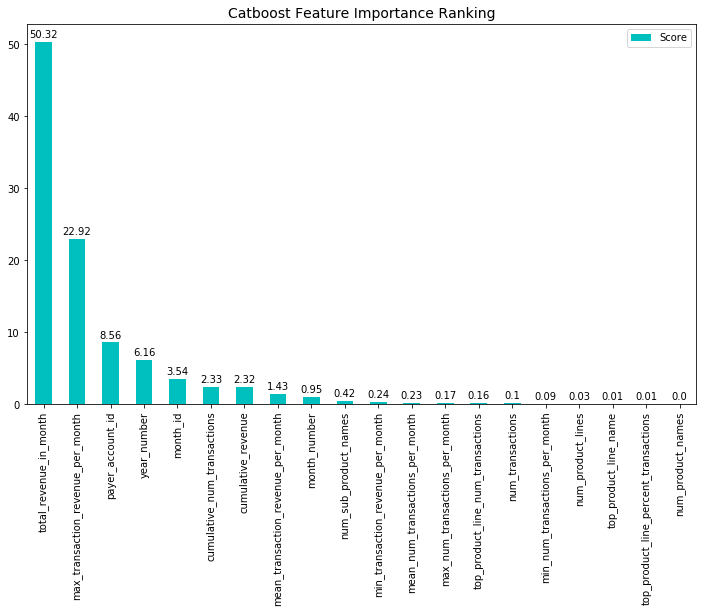

In [31]:
plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

The most important feature by far is the total revenue in the month, but that is part of the definition of churn: the revenue that month must be below 1. This also explains why we were able to get such a low logloss.. 

The next most important feature is the value of the largest transaction made that month. This is also a derivative of total revenue, so it stands to reason. The subsequent few features are account and date ids.

Finally we reach features with the highest feature importance that churn isn't derived from: cumulative_num_transactions and cumulative_revenue. This makes sense, since keeping track of the total spending and number of transactions an account has made should be a good indicator of whether it is going to churn. However, relative to even year_number and month_id these feature importances are low, which implies that they actually aren't very good predictors at all. 

Given more time, I would create more cumulative features, integrate some more account metadata if available, and try to find a way to incorporate the ordinal nature of payer-months into the model. I would also remove the features that churn is derived from to see how the model actually performs.

## Footnote
Along the way I ran into problems running queries that simply took too long, and I had to figure out what I was doing wrong... 

I starting with UPDATE to create calculated attributes:

In [ ]:
# Update monthly_sales_revenue with a column containing previous_dec_revenue

# create_prev_dec_revenue = """
#     ALTER TABLE monthly_sales_revenue
#     ADD COLUMN previous_dec_month_sales_revenue NUMERIC(38,6);
# """

# set_prev_dec_revenue = """
#     UPDATE monthly_sales_revenue 
#     SET previous_dec_month_sales_revenue = subquery.previous_dec_month_sales_revenue
#     FROM (SELECT msr.payer_account_id, msr.month_id, dc.month_number, dc.year_number, msr.month_sales_revenue, dc2.year_number AS previous_year_number, dc2.month_id AS previous_dec_month_id, msr2.month_sales_revenue AS previous_dec_month_sales_revenue
#         FROM monthly_sales_revenue msr
#         LEFT JOIN dim_calendar dc ON msr.month_id = dc.month_id
#         LEFT JOIN dim_calendar dc2 ON dc.year_number-1 = dc2.year_number AND dc2.month_number = 12
#         LEFT JOIN monthly_sales_revenue msr2 ON dc2.month_id = msr2.month_id) subquery
#     WHERE monthly_sales_revenue.payer_account_id = subquery.payer_account_id 
#     AND monthly_sales_revenue.month_id = subquery.month_id
# """

# execute_only(create_prev_dec_revenue)
# execute_only(set_prev_dec_revenue)

and when it took too long, I figured selecting into another table would be faster:

In [ ]:
# Creating a new table containing the previous_dec_revenue attribute, which should be faster than UPDATE

# %%time
# select_revenue_comparison = """
#     SELECT msr.payer_account_id, msr.month_id, dc.month_number, dc.year_number, msr.month_sales_revenue, dc2.year_number AS previous_year_number, dc2.month_id AS previous_dec_month_id, msr2.month_sales_revenue AS previous_dec_month_sales_revenue
#     INTO TABLE revenue_comparison
#     FROM monthly_sales_revenue msr
#         LEFT JOIN dim_calendar dc ON msr.month_id = dc.month_id
#         LEFT JOIN dim_calendar dc2 ON dc.year_number-1 = dc2.year_number AND dc2.month_number = 12
#         LEFT JOIN monthly_sales_revenue msr2 ON dc2.month_id = msr2.month_id
# """

# execute_only(select_revenue_comparison)

I tried using a function to store variables so that hopefully creating them procedurally would avoid consuming memory on the server:

In [ ]:
# Using a function to generate previous_dec_revenue procedurally

# function_previous_dec_revenue = """
#     CREATE FUNCTION previous_dec_monthly_sales_revenue(monthly_sales_revenue)
#     RETURNS NUMERIC(38,6) AS
#     $func$
#     SELECT previous_dec_month_sales_revenue 
#     FROM (SELECT msr.payer_account_id, msr.month_id, dc.month_number, dc.year_number, msr.month_sales_revenue, dc2.year_number AS previous_year_number, dc2.month_id AS previous_dec_month_id, msr2.month_sales_revenue AS previous_dec_month_sales_revenue
#         FROM monthly_sales_revenue msr
#         LEFT JOIN dim_calendar dc ON msr.month_id = dc.month_id
#         LEFT JOIN dim_calendar dc2 ON dc.year_number-1 = dc2.year_number AND dc2.month_number = 12
#         LEFT JOIN monthly_sales_revenue msr2 ON dc2.month_id = msr2.month_id) subquery
#     $func$ LANGUAGE SQL STABLE; 
# """

# execute_only(function_previous_dec_revenue)

None of the above approaches worked out in the sense of being able to be executed in a reasonable amount of time. In the case of the stored function, a simple select query with a very low limit faced the same problem.

So, I tried to break it down into smaller steps even if it winds up looking less elegant.

The first thing to do is make sure that I'm not crazy, and that my SQL works. Since instances where there was no transaction will come up as NULL, I'll omit those and limit the result to 500 rows:

In [ ]:
# %%time
# test_revenue_comparison = """
# SELECT msr.payer_account_id, msr.month_id, dc.month_number, dc.year_number, msr.month_sales_revenue, dc2.year_number AS previous_year_number, dc2.month_id AS previous_dec_month_id, msr2.month_sales_revenue AS previous_dec_month_sales_revenue
#     FROM monthly_sales_revenue msr
#     LEFT JOIN dim_calendar dc ON msr.month_id = dc.month_id
#     LEFT JOIN dim_calendar dc2 ON dc.year_number-1 = dc2.year_number AND dc2.month_number = 12
#     LEFT JOIN monthly_sales_revenue msr2 ON dc2.month_id = msr2.month_id
# WHERE msr2.month_sales_revenue IS NOT NULL
# LIMIT 500;
# """

# test_revenue_comparison_df = psql.read_sql(test_revenue_comparison, conn)
# print(test_revenue_comparison_df.head())

In [ ]:
# test_revenue_baseline = """
#     SELECT payer_account_id, month_id, month_sales_revenue 
#     FROM monthly_sales_revenue
#     WHERE payer_account_id LIKE 'PA000000000005593129'
#     AND month_id = 201512;
# """

# select_print(test_revenue_baseline)

No reason that wouldn't have been right, but it couldn't be any clearer after seeing the result of these two queries match up.

At this point I thought that I would have to index the tables, which I didn't want to do because I figured it wouldn't be worth it since I would only be querying them once to create the churn table which I would be using for my analysis.

At this point, I realized my mistake: The dim_calendar table is aggregated on a daily basis! Every join on month_id was duplicating the entire table ~30 times, and since I was joining twice that was 900 times. 

Using EXPLAIN also led me to realize that I also made an error in the LEFT JOIN of msr2; I have to join it on payer_account_id as well.

In [ ]:
# Used to clean up commits if an error is thrown.

curs = conn.cursor()
curs.execute("ROLLBACK")
conn.commit()